https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.structural.UnobservedComponents.html

In [1]:
#pip install Prophet

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
import random
import statsmodels.api as sm
import scipy
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error as MAPE


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train.csv', parse_dates=['first_day_of_month'])
test=pd.read_csv('test.csv', parse_dates=['first_day_of_month'])
census=pd.read_csv('census_starter.csv')

In [4]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [5]:
train.dtypes

row_id                           object
cfips                             int64
county                           object
state                            object
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                            int64
dtype: object

In [7]:
test.head()

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01


In [8]:
test=test.sort_values(['cfips','first_day_of_month']).reset_index(drop=True)
test.head()


,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1001_2022-12-01,1001,2022-12-01
2,1001_2023-01-01,1001,2023-01-01
3,1001_2023-02-01,1001,2023-02-01
4,1001_2023-03-01,1001,2023-03-01


# Visualization and exploratory data analysis

In [104]:
# Visualize data
unique_cfips= train.cfips.unique()
len(unique_cfips)

3135

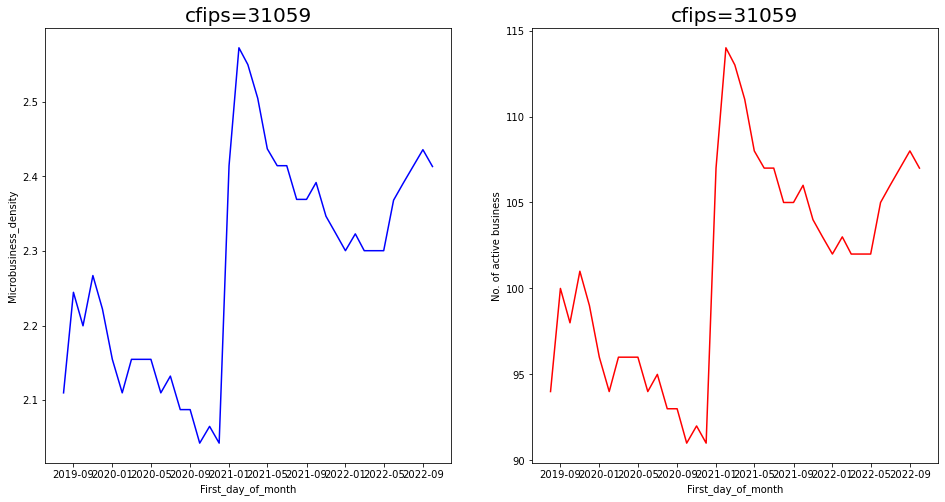

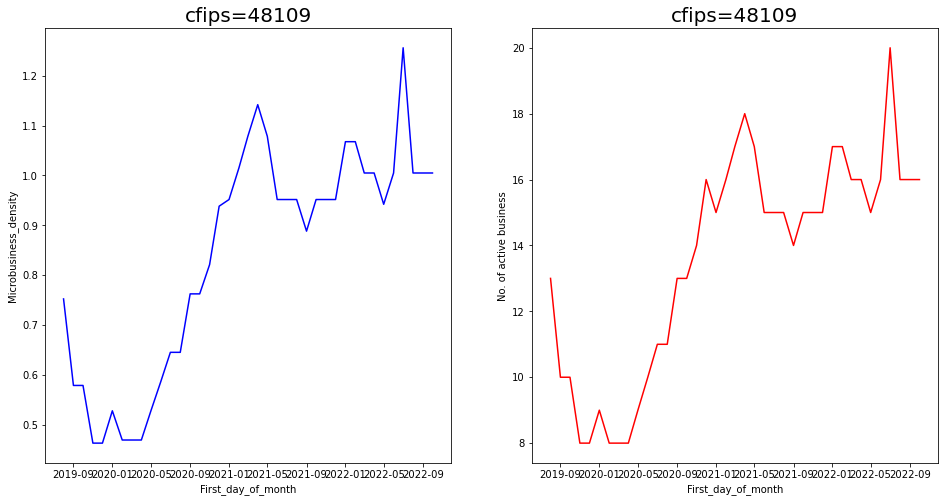

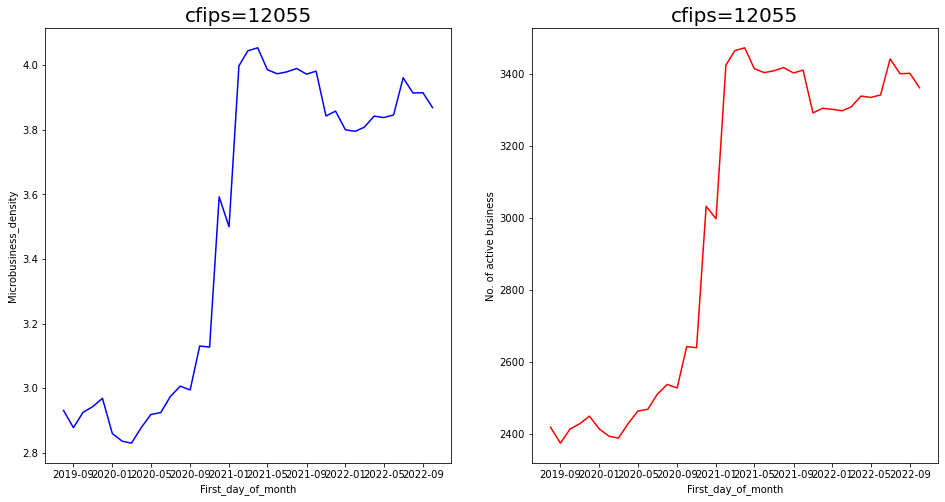

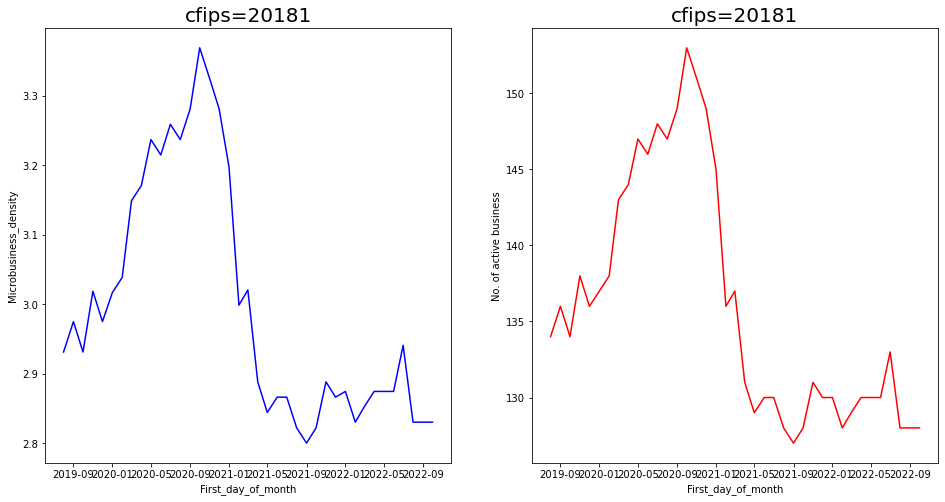

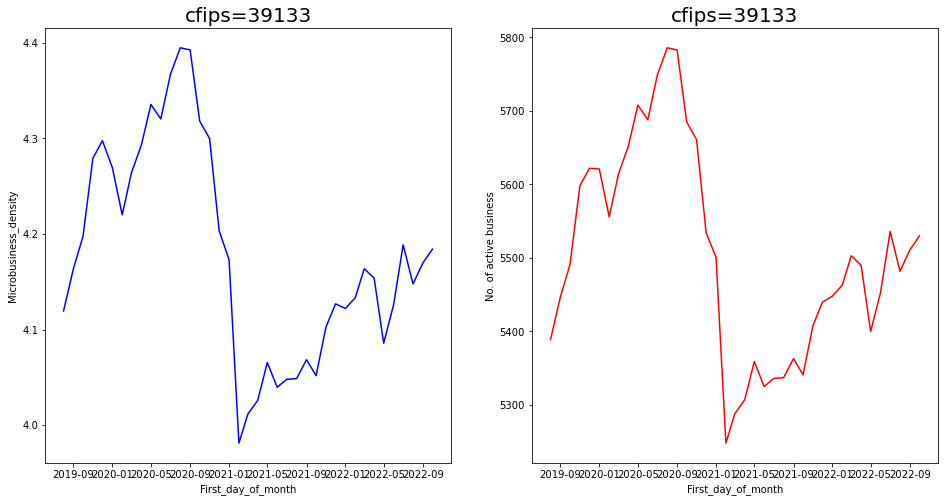

In [10]:
for i in random.choices(unique_cfips,k=5):
    df=train[train.cfips==i]
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,8))
    ax[0].plot(df.first_day_of_month,df.microbusiness_density,'b-')
    ax[0].set_xlabel('First_day_of_month')
    ax[0].set_ylabel('Microbusiness_density')
    ax[0].set_title(f'cfips={i}',fontsize=20)
    ax[1].plot(df.first_day_of_month,df.active,'r-')
    ax[1].set_xlabel('First_day_of_month')
    ax[1].set_ylabel('No. of active business')
    ax[1].set_title(f'cfips={i}',fontsize=20)


## Smooth trend model without seasonal or cyclical components

##### model parameters

In [11]:
model={
    'level':'smooth trend',
    'cycle':False,'seasonal':False,
}

### fit models for sample counties

cfips= 30023
cfips= 48065
cfips= 42129
cfips= 12059
cfips= 13153


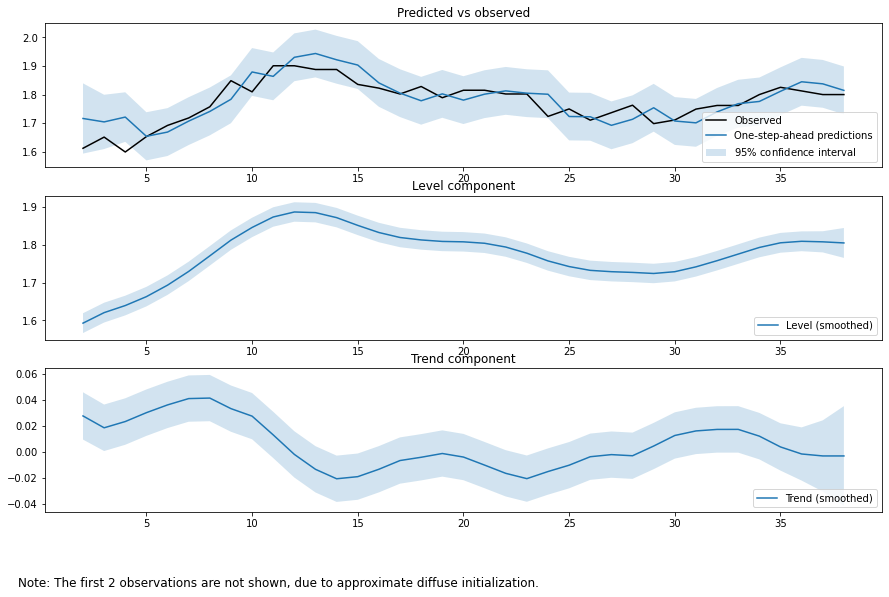

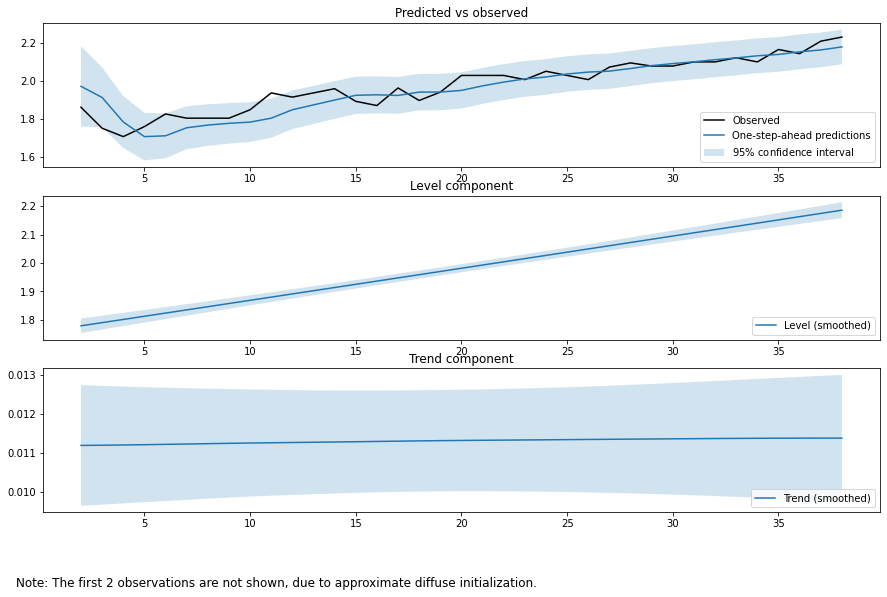

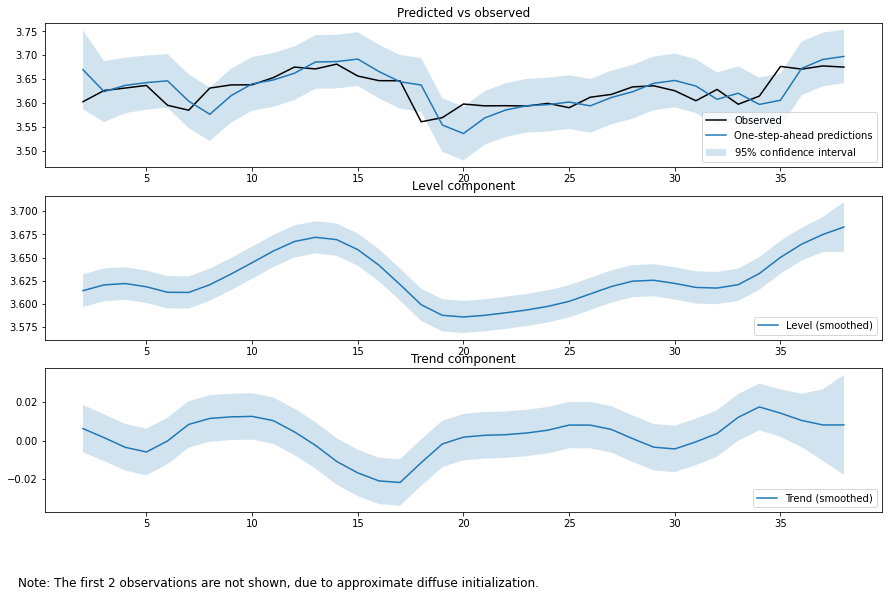

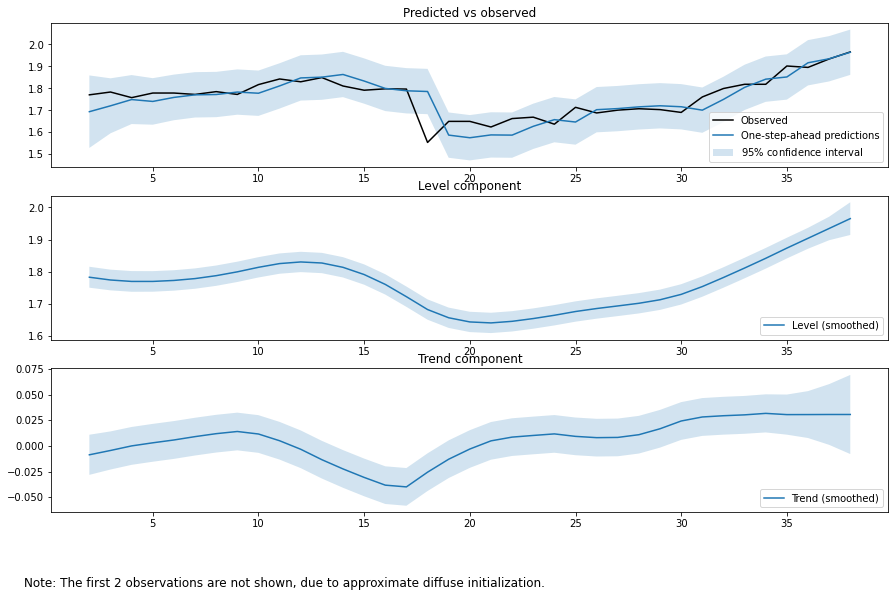

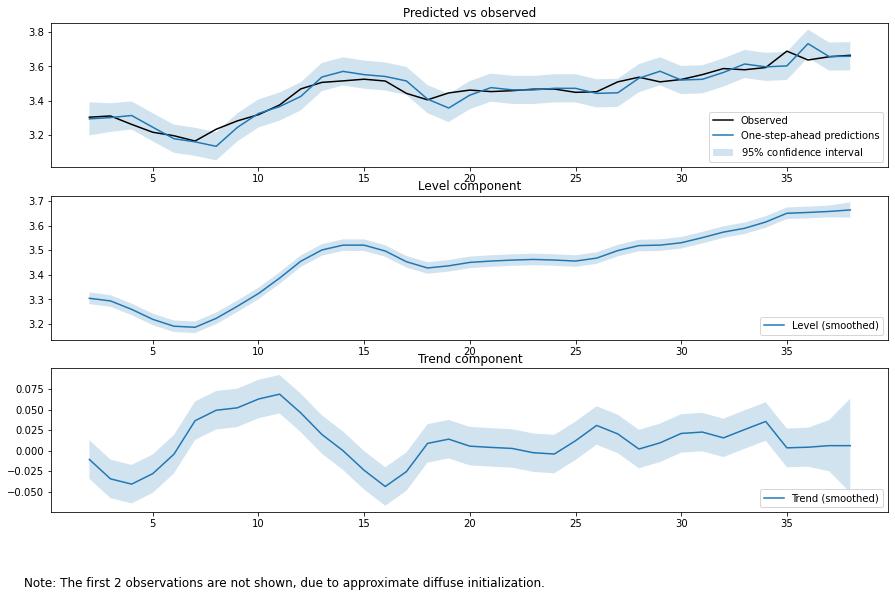

In [12]:
for i in random.choices(unique_cfips,k=5):
    df=train[train.cfips==i]
    first_model=sm.tsa.UnobservedComponents(df.microbusiness_density,**model)
    first_model_res=first_model.fit()
    fig=first_model_res.plot_components(legend_loc='lower right',figsize=(15,9))
    print('cfips=',i)

### Plotting predictions

In [13]:
#perform rolling prediction and multistep forecast
num_steps=8
predict_res=first_model_res.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
predict=predict_res.predicted_mean
ci=predict_res.conf_int()

In [14]:
predict.shape

(39,)

In [15]:
predict[-9:-1].values

array([3.52021521, 3.52445171, 3.52615184, 3.52785197, 3.5295521 ,
       3.53125223, 3.53295236, 3.53465249])

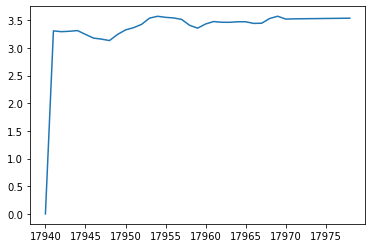

In [16]:
plt.plot(predict)

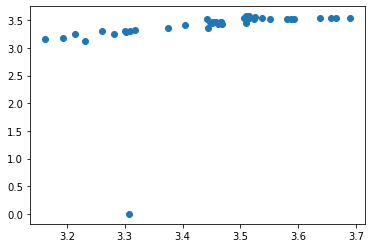

In [17]:
plt.scatter(df.microbusiness_density,predict)


### Prediction

In [ ]:
y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [ ]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

In [ ]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

In [ ]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_ns_1.csv',index=False) 
## This resulted in LB score 6.4. Pretty bad!

## Smooth trend model with seasonal  components

In [19]:
model_seasonal={
    'level':'smooth trend',
    'cycle':False,'seasonal':12,
}

y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model_seasonal)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [20]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.443976
0    3.382755
0    3.461768
0    3.471103
0    3.482288
dtype: object

In [21]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.443976
1,1001_2022-12-01,1001,2022-12-01,3.382755
2,1001_2023-01-01,1001,2023-01-01,3.461768
3,1001_2023-02-01,1001,2023-02-01,3.471103
4,1001_2023-03-01,1001,2023-03-01,3.482288


In [23]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_2.csv',index=False) 
#This had even higher SMAPE of 9. Need to optimize more!

## local linear trend without seasonality

In [25]:
model_lineartrend={
    'level':'local linear trend',
    'cycle':False,'damped_cycle': False,'stochastic_cycle': False,
}

y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model_lineartrend)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [26]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.280254
0    3.303815
0    3.317176
0    3.330536
0    3.343896
dtype: object

In [27]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.280254
1,1001_2022-12-01,1001,2022-12-01,3.303815
2,1001_2023-01-01,1001,2023-01-01,3.317176
3,1001_2023-02-01,1001,2023-02-01,3.330536
4,1001_2023-03-01,1001,2023-03-01,3.343896


In [28]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_3.csv',index=False) 

## Local linear trend-stochastic-cycle

In [37]:
model_lineartrend_st={
    'level':'local linear trend',
    'cycle':True,'damped_cycle': False,'stochastic_cycle': True,
}

y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model_lineartrend_st)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [38]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.303518
0     3.34946
0    3.361444
0    3.366548
0    3.377263
dtype: object

In [39]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.303518
1,1001_2022-12-01,1001,2022-12-01,3.34946
2,1001_2023-01-01,1001,2023-01-01,3.361444
3,1001_2023-02-01,1001,2023-02-01,3.366548
4,1001_2023-03-01,1001,2023-03-01,3.377263


In [40]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_4.csv',index=False) 
## SMAPE 6.48. More improvement needed.

## Random walk

In [7]:
model_randomwalk={
    'level':'random walk',
    'cycle':True,'stochastic_cycle': True,
}

y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model_randomwalk)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [8]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.293294
0    3.340884
0    3.341811
0    3.335384
0    3.334286
dtype: object

In [11]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.293294
1,1001_2022-12-01,1001,2022-12-01,3.340884
2,1001_2023-01-01,1001,2023-01-01,3.341811
3,1001_2023-02-01,1001,2023-02-01,3.335384
4,1001_2023-03-01,1001,2023-03-01,3.334286


In [10]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_rw_6.csv',index=False) 
## SMAPE 6.442. More improvement needed.

### Random walk  with drift

In [19]:
model_randomwalk={
    'level':'random walk with drift',
    'cycle':False,'stochastic_cycle': False,
}

y_forecast=[]
num_steps=8
for i in unique_cfips:
    df=train[train.cfips==i]
    model_=sm.tsa.UnobservedComponents(df.microbusiness_density,**model_randomwalk)
    model_=model_.fit()
    #perform rolling prediction and multistep forecast
    predict_=model_.get_prediction(dynamic=df.microbusiness_density.shape[0]-num_steps)
    y_predict=predict_.predicted_mean[-9:-1].values
    y_forecast.append(y_predict)

In [20]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0     3.30675
0    3.345323
0    3.356215
0    3.367106
0    3.377998
dtype: object

In [21]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.30675
1,1001_2022-12-01,1001,2022-12-01,3.345323
2,1001_2023-01-01,1001,2023-01-01,3.356215
3,1001_2023-02-01,1001,2023-02-01,3.367106
4,1001_2023-03-01,1001,2023-03-01,3.377998


In [15]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_sts_rwd_2.csv',index=False) 
## SMAPE 6.58. More improvement needed.

## The Theta model
The Theta model of Assimakopoulos & Nikolopoulos (2000) is a simple method for forecasting the involves fitting two -lines, forecasting the lines using a Simple Exponential Smoother, and then combining the forecasts from the two lines to produce the final forecast. The model is implemented in steps:

- Test for seasonality

- Deseasonalize if seasonality detected

- Estimate  by fitting a SES model to the data and b0 by OLS.

- Forecast the series

- Reseasonalize if the data was deseasonalized.


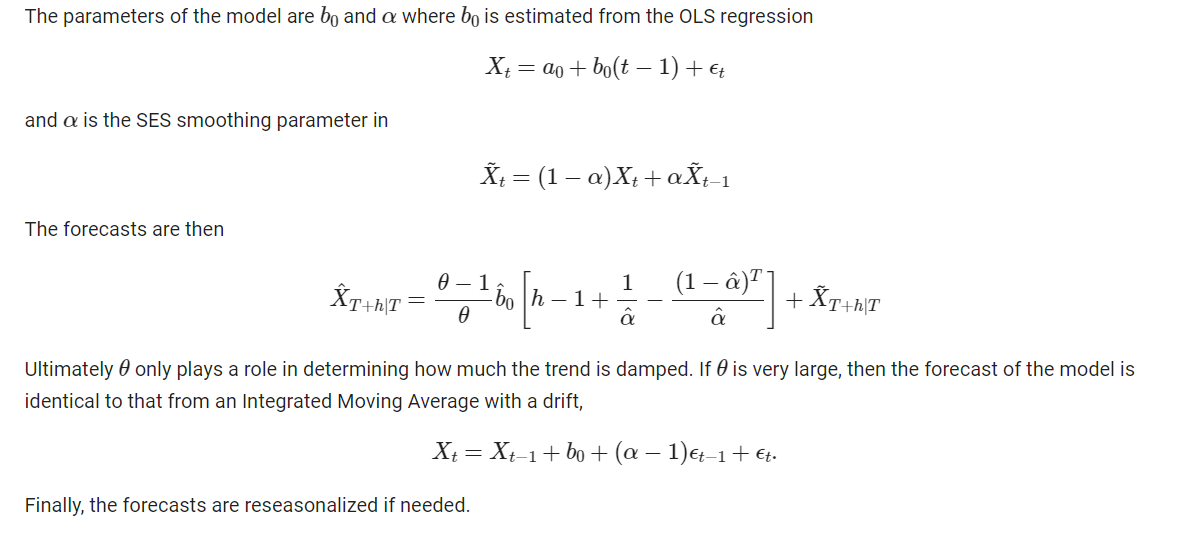
This module is based on:

Assimakopoulos, V., & Nikolopoulos, K. (2000). The theta model: a decomposition approach to forecasting. International journal of forecasting, 16(4), 521-530.

Hyndman, R. J., & Billah, B. (2003). Unmasking the Theta method. International Journal of Forecasting, 19(2), 287-290.

Fioruci, J. A., Pellegrini, T. R., Louzada, F., & Petropoulos, F. (2015). The optimized theta method. arXiv preprint arXiv:1503.03529.

In [249]:
unique_cfips[:20]

array([1001, 1003, 1005, 1007, 1009, 1011, 1013, 1015, 1017, 1019, 1021,
       1023, 1025, 1027, 1029, 1031, 1033, 1035, 1037, 1039], dtype=int64)

In [18]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [236]:
df=train[train.cfips==1029]

In [270]:
tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
res=tm.fit()#use_mle=True
fcast=pd.DataFrame(res.forecast(8,theta=np.inf))
print(res.summary())

                                ThetaModel Results                               
Dep. Variable:     microbusiness_density   No. Observations:                   39
Method:                          OLS/SES   Deseasonalized:                   True
Date:                   Tue, 10 Jan 2023   Deseas. Method:               Additive
Time:                           01:36:03   Period:                              3
Sample:                       08-01-2019                                         
                            - 10-01-2022                                         
    Parameter Estimates    
            Parameters     
---------------------------
b0    0.0034460430026990486
alpha    0.6606691405226373
---------------------------


In [271]:
#pip install Prophet

In [272]:
date_range=pd.date_range(start='11-01-22',end='06-01-23',freq='MS')

In [273]:
fcast['first_day_of_month']=date_range
fcast=fcast.set_index('first_day_of_month')
fcast.head()

,forecast
first_day_of_month,
2022-11-01,1.357953
2022-12-01,1.366686
2023-01-01,1.364642
2023-02-01,1.368291
2023-03-01,1.377024


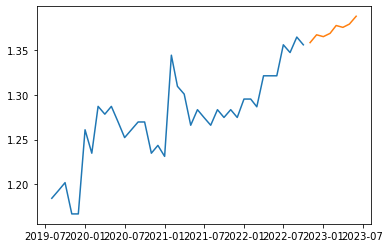

In [274]:
plt.plot(df.microbusiness_density)
plt.plot(fcast)

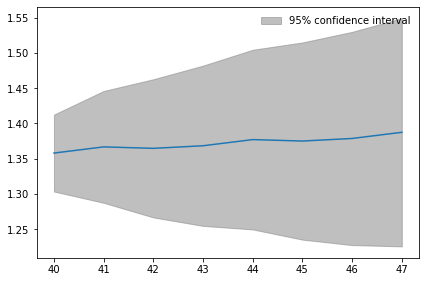

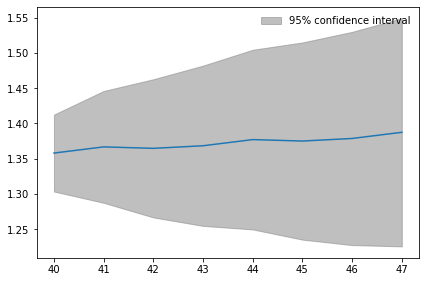

In [268]:
res.plot_predict(8,theta=np.inf)

In [269]:
res.forecast_components(8)

,trend,ses,seasonal
40,0.005216,1.354432,-0.001695
41,0.008662,1.354432,0.003593
42,0.012108,1.354432,-0.001898
43,0.015554,1.354432,-0.001695
44,0.019000,1.354432,0.003593
45,0.022446,1.354432,-0.001898
46,0.025892,1.354432,-0.001695
47,0.029338,1.354432,0.003593


In [9]:
train=train.set_index('first_day_of_month')
train.head()

,row_id,cfips,county,state,microbusiness_density,active
first_day_of_month,,,,,,
2019-08-01,1001_2019-08-01,1001,Autauga County,Alabama,3.007682,1249
2019-09-01,1001_2019-09-01,1001,Autauga County,Alabama,2.884870,1198
2019-10-01,1001_2019-10-01,1001,Autauga County,Alabama,3.055843,1269
2019-11-01,1001_2019-11-01,1001,Autauga County,Alabama,2.993233,1243
2019-12-01,1001_2019-12-01,1001,Autauga County,Alabama,2.993233,1243


In [163]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit(use_mle=True)
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [164]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476801
0    3.489155
0    3.501508
0    3.513862
0    3.526215
dtype: object

In [165]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476801
1,1001_2022-12-01,1001,2022-12-01,3.489155
2,1001_2023-01-01,1001,2023-01-01,3.501508
3,1001_2023-02-01,1001,2023-02-01,3.513862
4,1001_2023-03-01,1001,2023-03-01,3.526215


In [166]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_1.csv',index=False) 
## SMAPE1.771. A dramatic improvements from previous models.

##### OLE/OLS method

In [187]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [188]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [189]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [190]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_2.csv',index=False) 
## SMAPE1.5784. A dramatic improvements from previous models.

#### theta=3

In [200]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=3)
    y_forecast.append(forecast_)

In [201]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.471807
0    3.480609
0    3.489412
0    3.498215
0    3.507018
dtype: object

In [202]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.471807
1,1001_2022-12-01,1001,2022-12-01,3.480609
2,1001_2023-01-01,1001,2023-01-01,3.489412
3,1001_2023-02-01,1001,2023-02-01,3.498215
4,1001_2023-03-01,1001,2023-03-01,3.507018


In [203]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_3.csv',index=False) 
## SMAPE 1.421. A dramatic improvements from previous models.

#### theta=2

In [204]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=2)
    y_forecast.append(forecast_)

In [205]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.469451
0    3.476053
0    3.482655
0    3.489257
0     3.49586
dtype: object

In [206]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.469451
1,1001_2022-12-01,1001,2022-12-01,3.476053
2,1001_2023-01-01,1001,2023-01-01,3.482655
3,1001_2023-02-01,1001,2023-02-01,3.489257
4,1001_2023-03-01,1001,2023-03-01,3.49586


In [207]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_4.csv',index=False) 
## SMAPE 1.3608. A dramatic improvements from previous models.

#### theta=1.5

In [208]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive')
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1.5)
    y_forecast.append(forecast_)

In [209]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.467096
0    3.471497
0    3.475899
0      3.4803
0    3.484701
dtype: object

In [210]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.467096
1,1001_2022-12-01,1001,2022-12-01,3.471497
2,1001_2023-01-01,1001,2023-01-01,3.475899
3,1001_2023-02-01,1001,2023-02-01,3.4803
4,1001_2023-03-01,1001,2023-03-01,3.484701


In [211]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_5.csv',index=False) 
## SMAPE 1.3085. A dramatic improvements from previous models.

### Hyperparameter tuning-Theta model

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [100]:
df=train[train.cfips==1009].microbusiness_density
df_train=df[:24]
df_val=pd.Series(df[24:])

In [231]:
periods=[3,6,12]
use_mle=[True,False]
thetas=[np.inf,1,2,3]
for cfips in random.choices(unique_cfips,k=20):
    print(f'cfips={cfips}')
    list_=[]
    df=train[train.cfips==cfips].microbusiness_density
    df_train=df[:31]
    df_val=pd.Series(df[31:])
    for period in periods:
        tm=ThetaModel(df_train,method='additive',period=period)
        for i in use_mle:
            res=tm.fit(use_mle=i)#use_mle=True
            for theta in thetas:
                forecast_=pd.Series(res.forecast(8,theta=theta))
                list_.append(((f'period:{period}, use_mle:{i}, theta:{theta}'),MAPE(df_val,forecast_)))
    print('Best_parameters:',sorted(list(enumerate(list_)),key= lambda x:x[1][1])[0])

cfips=13011
Best_parameters: (8, ('period:6, use_mle:True, theta:inf', 0.056452348464691084))
cfips=37087
Best_parameters: (3, ('period:3, use_mle:True, theta:3', 0.0046297056772889745))
cfips=28139
Best_parameters: (2, ('period:3, use_mle:True, theta:2', 0.00866027915897391))
cfips=1065
Best_parameters: (5, ('period:3, use_mle:False, theta:1', 0.016593946163203928))
cfips=48183
Best_parameters: (12, ('period:6, use_mle:False, theta:inf', 0.004581801025720908))
cfips=1047
Best_parameters: (11, ('period:6, use_mle:True, theta:3', 0.006981085752267899))
cfips=28159
Best_parameters: (0, ('period:3, use_mle:True, theta:inf', 0.07826937636389422))
cfips=53043
Best_parameters: (0, ('period:3, use_mle:True, theta:inf', 0.011842397530133213))
cfips=50023
Best_parameters: (5, ('period:3, use_mle:False, theta:1', 0.01456266407795298))
cfips=30085
Best_parameters: (12, ('period:6, use_mle:False, theta:inf', 0.14529998303803698))
cfips=5067
Best_parameters: (5, ('period:3, use_mle:False, theta:1',

### period=12,theta=1,use_mle=false

In [137]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [138]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.462385
0    3.462385
0    3.462385
0    3.462385
0    3.462385
dtype: object

In [139]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.462385
1,1001_2022-12-01,1001,2022-12-01,3.462385
2,1001_2023-01-01,1001,2023-01-01,3.462385
3,1001_2023-02-01,1001,2023-02-01,3.462385
4,1001_2023-03-01,1001,2023-03-01,3.462385


In [140]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_6.csv',index=False) 
## SMAPE 1.171. This is the best score so far.

### period=3, theta=1,use_mle=false

In [163]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [164]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.440106
0    3.463908
0    3.444323
0    3.440106
0    3.463908
dtype: object

In [165]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.440106
1,1001_2022-12-01,1001,2022-12-01,3.463908
2,1001_2023-01-01,1001,2023-01-01,3.444323
3,1001_2023-02-01,1001,2023-02-01,3.440106
4,1001_2023-03-01,1001,2023-03-01,3.463908


In [166]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_7.csv',index=False) 
## SMAPE 1.46. A dramatic improvements from previous models.

### period=3, theta=inf,

In [167]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=3)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [168]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.453612
0    3.490567
0    3.484134
0     3.49307
0    3.530025
dtype: object

In [169]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.453612
1,1001_2022-12-01,1001,2022-12-01,3.490567
2,1001_2023-01-01,1001,2023-01-01,3.484134
3,1001_2023-02-01,1001,2023-02-01,3.49307
4,1001_2023-03-01,1001,2023-03-01,3.530025


In [171]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_8.csv',index=False) 
## SMAPE 1.71. Increased!

###  period=12, theta=1,use_mle=True

In [172]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit(use_mle=True)
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=1)
    y_forecast.append(forecast_)

In [173]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.462683
0    3.462683
0    3.462683
0    3.462683
0    3.462683
dtype: object

In [174]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.462683
1,1001_2022-12-01,1001,2022-12-01,3.462683
2,1001_2023-01-01,1001,2023-01-01,3.462683
3,1001_2023-02-01,1001,2023-02-01,3.462683
4,1001_2023-03-01,1001,2023-03-01,3.462683


In [176]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_9.csv',index=False) 
## SMAPE 1.3835.

### period=12,theta=inf,use_mle-false

In [177]:
y_forecast=[]
for i in unique_cfips:
    df=train[train.cfips==i]
    tm=ThetaModel(df.microbusiness_density,method='additive',period=12)
    res=tm.fit()
    #perform rolling prediction and multistep forecast
    forecast_=res.forecast(8,theta=np.inf)
    y_forecast.append(forecast_)

In [178]:
y_fore=pd.Series(y_forecast).explode()
y_fore.head()

0    3.476518
0    3.489722
0    3.502926
0     3.51613
0    3.529334
dtype: object

In [179]:
test['microbusiness_density']=y_fore.reset_index(drop=True)
test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.476518
1,1001_2022-12-01,1001,2022-12-01,3.489722
2,1001_2023-01-01,1001,2023-01-01,3.502926
3,1001_2023-02-01,1001,2023-02-01,3.51613
4,1001_2023-03-01,1001,2023-03-01,3.529334


In [180]:
sub=test[['row_id','microbusiness_density']]
sub.to_csv('submission_tm_10.csv',index=False) 
## SMAPE 1.58. A dramatic improvements from previous models.